# Lab 1 (Tidy Data): A Simple Exploration of FEMA Public Assistance Trajectories following Hurricane Sandy in New York City, 2012 - 2016
### Joe Tuccillo

Following a presidential disaster declaration, [FEMA Public Assistance (PA)](https://www.fema.gov/public-assistance-local-state-tribal-and-non-profit) becomes available for public and private organizations to perform emergency response, as well as cleanup, repairs, and abatement upon critical infrastructure/facilities. As part of its [Sandy Funding Tracker](http://www1.nyc.gov/sandytracker/), the City of New York publishes [a series of PA datasets](http://www1.nyc.gov/sandytracker/#1745382431) by *agency* - which here refers to different types of critical infrastructure/facility projects, as well as smaller-scale contract or community projects. In a simple exploration of PA data for Hurricane Sandy in New York City (2012-2016), I consider different monthly trajectories of active PA cases by agency.

### Data Prep

In [107]:
## Load libraries and data

# Carson's 'boilerplate' libraries
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns  # I played with `sns.tsplot`, but it didn't work...
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 8, 4
from pandas import Series, DataFrame, Panel

# other libraries
import os
from glob import glob
import copy
from ggplot import *

# Read in FEMA Public Assistance Data
fpa=pd.DataFrame()
for f in os.listdir("data"):
    fc=pd.read_csv(os.path.join("data",f)) # read in df
    fc['Agency']=[f.replace(' - CONTRACTS.csv','')]*len(fc) # add Agency field
    fpa=fpa.append(fc) # append to main df

# Convert date fields to datetime
# FIX so that this is iterative!!
fpa['Current Start Date']=pd.to_datetime(fpa['Current Start Date'])
fpa['Current End Date']=pd.to_datetime(fpa['Current End Date'])
fpa['Original Start Date']=pd.to_datetime(fpa['Original Start Date'])
fpa['Original End Date']=pd.to_datetime(fpa['Original End Date'])

### Building a PA Time Series

The original data, like much of what's available through the Sandy Recovery Tracker, already looks fairly tidy. I'm guessing City of New York might already use a tidy data standard. Every observation is already matched to a set of variables/values corresponding to each contract ID, plus the agency type, which I added:

In [96]:
fpa.head()

,Contractor Name,Contract ID,Purpose,Value of Sandy Funding,Sandy Spending to Date,Current Start Date,Current End Date,Original Start Date,Original End Date,Procurement Method,Estimated Job Creation,Agency
0,A RUSSO WRECKING INC,CT180620131422906,CONSTRUCTION,124111,112178,2013-02-20,2014-02-19,2013-02-20,2014-02-19,EMERGENCY,1,Buildings and Other Housing Contracts
1,A RUSSO WRECKING INC,CT180620141400965,CONSTRUCTION,598444,341943,2013-04-22,2014-04-21,2013-04-22,2014-04-21,EMERGENCY,2,Buildings and Other Housing Contracts
2,A RUSSO WRECKING INC,CT180620141406976,CONSTRUCTION,352222,321722,2013-06-10,2014-06-09,2013-06-10,2014-06-09,EMERGENCY,2,Buildings and Other Housing Contracts
3,A RUSSO WRECKING INC,CT180620141410906,CONSTRUCTION,235222,235222,2013-06-17,2014-06-16,2013-06-17,2014-06-16,EMERGENCY,1,Buildings and Other Housing Contracts
4,APEX MECHANICAL CORP,CT180620111435192,REQUIREMENTS-SERVICES,115765,115765,2011-05-02,2013-05-01,2011-05-17,2013-05-16,COMPETITIVE SEALED BIDDING,1,Buildings and Other Housing Contracts


However, while current start/end date fields provide a sense of the temporal span of each project, the formatting of this dataset still obscures understanding of **how many public assistance projects by agency were active over time**.

To play with tidying a bit more, I decided to investigate the trajectories (frequencies) of **active recovery cases by agency 2012 - 2016**. Monthly intervals were set at the final date of each month since Sandy's landfall (October 29, 2012), to present (September 30, 2016), providing a roughly four-year observation period.

In [97]:
# range of monthly (end of month) dates since Sandy
srcv_dates=pd.date_range(start='2012-10-29',end='2016-10-29',freq='M')
srcv_dates

DatetimeIndex(['2012-10-31', '2012-11-30', '2012-12-31', '2013-01-31',
               '2013-02-28', '2013-03-31', '2013-04-30', '2013-05-31',
               '2013-06-30', '2013-07-31', '2013-08-31', '2013-09-30',
               '2013-10-31', '2013-11-30', '2013-12-31', '2014-01-31',
               '2014-02-28', '2014-03-31', '2014-04-30', '2014-05-31',
               '2014-06-30', '2014-07-31', '2014-08-31', '2014-09-30',
               '2014-10-31', '2014-11-30', '2014-12-31', '2015-01-31',
               '2015-02-28', '2015-03-31', '2015-04-30', '2015-05-31',
               '2015-06-30', '2015-07-31', '2015-08-31', '2015-09-30',
               '2015-10-31', '2015-11-30', '2015-12-31', '2016-01-31',
               '2016-02-29', '2016-03-31', '2016-04-30', '2016-05-31',
               '2016-06-30', '2016-07-31', '2016-08-31', '2016-09-30'],
              dtype='datetime64[ns]', freq='M')

Dataframes containing active cases at each reference date were appended iteratively to a "FEMA Public Assistance Time Series" (`fpats`) dataframe. For each reference date's dataframe, counts of active cases were aggregated by agency type 

$$N_t=\sum_{k=1}^nk\in A$$

where $N_t$ is the sum of the number of cases $k$ belonging to agency $A$ at time $t$.

In [98]:
# assemble the data
fpats=pd.DataFrame()
for d in srcv_dates:
    
    # Get active projects at date `d`
    active=fpa[(fpa['Current Start Date']<=d) & (fpa['Current End Date']>=d)]
    active['Count']=[1]*len(active) # count of active projects - is there a simpler way to do this?
    
    # Aggregate (sum) the active projects
    active=active.groupby(['Agency','Purpose','Procurement Method']).sum()
    active['Date']=[d]*len(active) # create date column
#     active['Type']=active.index # rownames as data - our 'object' reference
    
    # Unpack the aggregation multiIndex into separate col's
    for i in range(len(active.index.levels)):
        active[active.index.levels[i].name]=active.index.get_level_values(i).astype(str)
        
    active.index=active['Date'] # sub current date in as index
    
    active=active.loc[:,('Agency','Purpose','Procurement Method','Count')]
    
    # append to main df `fpats`
    fpats=fpats.append(active)

C:\Users\jtucc\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [99]:
# Now tidier!
fpats.head()

,Agency,Purpose,Procurement Method,Count
Date,,,,
2012-10-31,Buildings and Other Housing Contracts,REQUIREMENTS-SERVICES,COMPETITIVE SEALED BIDDING,1
2012-10-31,Hospitals Contracts,CONSTRUCTION,COMPETITIVE SEALED BIDDING,2
2012-10-31,Hospitals Contracts,REQUIREMENTS-CONSTRUCTION,COMPETITIVE SEALED BIDDING,1
2012-10-31,Hospitals Contracts,REQUIREMENTS-CONSTRUCTION,EMERGENCY,2
2012-10-31,Hospitals Contracts,REQUIREMENTS-SERVICES,MULTIPLE AWARDS,1


### Data Exploration

Upon **first glance at the data**, it appears that active public assistance contracts have slowed down quite a bit since immediately after Sandy (to be expected).

In [100]:
# Immediately after Sandy
fpats.ix[min(fpats.index)].groupby('Agency').sum()

,Count
Agency,
Buildings and Other Housing Contracts,1
Hospitals Contracts,6
Other Agencies Contracts,62
Parks Contracts,7
Roads and Bridges Contracts,12
Schools Contracts,1
Uniformed Agencies Contracts,15


In [101]:
# As of last Friday, 9/30/2016
fpats.ix[max(fpats.index)].groupby('Agency').sum()

,Count
Agency,
Hospitals Contracts,1
Other Agencies Contracts,3
Parks Contracts,2
Roads and Bridges Contracts,5
Uniformed Agencies Contracts,10


Since the data is tidy, we can also inspect **activity in individual agencies' contracts over time**. Roads and bridges contracts, for example, appear to hit their peak around mid-2014.

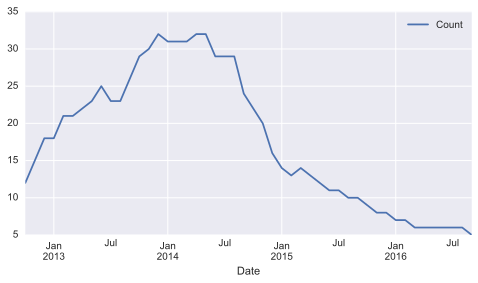

In [102]:
# Example: number of active Roads and Bridges contracts over time
agct=fpats[fpats['Agency']=='Roads and Bridges Contracts']
agct.groupby(agct.index).sum().plot() # all roads and bridges contacts

### Full Time Series

The python implementation of `ggplot` does not appear to have fully functional faceting support as of now, so I stuck with plotting all agency types together. 

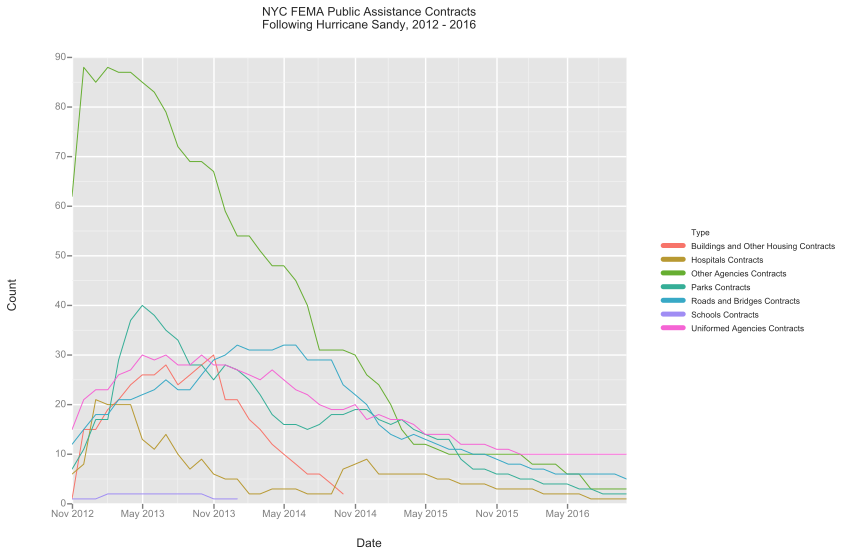

<ggplot: (109308559571)>

In [104]:
# Plot all - original plot
fplot=fpats.loc[:,['Agency','Count','Date']].groupby(['Agency','Date']).sum()
fplot['Type']=fplot.index.get_level_values(0) # retrieve the agency names - how to groupby without moving groups into index?
fplot['Date']=fplot.index.get_level_values(1) # get dates, same method/issue

# Plot
# actually, maybe I can use 'stat_bin' vs. 'groupby'...
ggplot(fplot,aes(x='Date',y='Count',colour='Type')) + \
    geom_line() + \
    ggtitle("NYC FEMA Public Assistance Contracts\nFollowing Hurricane Sandy, 2012 - 2016")

#### Some Initial Observations

* Active public assistance contracts as a whole began decreasing around November 2014.
* Many active contracts extend to **Other Agencies**. These include community, religious, and non-governmental organizations and private companies. These were numerous from about a month following Sandy into May 2013, when their numbers sharply decreased - although still numerous relative to other categories until late 2014. The sheer number of these contracts might suggest that they were smaller contracts than other agencies, for example Roads and Bridges. Further, the rapid uptick/decline in these contracts may suggest relief efforts undertaken following the storm.
* **Uniformed Agencies**, also largely private orgainzations providing labor/supplies for Sandy recovery, similarly established contracts immediately after Sandy and remained consistently active until late 2014.
* Contracts for **Hospitals** were quickly established in the month following Sandy (Nov 2013) and continued into mid-2013. This suggests that agencies with immediate needs for assistance may have been active in procuring funding after the storm.
* Active **Road and Bridges** contracts continued to climb from Sandy's aftermath to a late peak in May 2014. These could point to lag effects in conracts; or perhaps prioritization of larger repair projects immediately following the storm, and smaller projects as the recovery process continued (or vice-versa). 
* **Buildings and Housing** contracts followed a similar trajectory to roads and bridges until November 2013, when the number of active contracts sharply dropped.
* **Parks** contracts peaked sharply in May 2013 - coordinated action among city agencies?

### A Closer Look

Let's quickly explore numbers of active contracts relative to `Purpose` (i.e. Construction) and `Procurement Methods` (i.e. Emergency vs. Intragovernmental assistance).

In [ ]:
## Generate a simplified df for plotting

fplot_simp=copy.deepcopy(fpats) # ensure the original `fpats` is preserved

# Preserve emergency & competitive sealed bidding cat's 
# just the two most frequent
fplot_simp['Procurement Method']=np.where(fplot_simp['Procurement Method']=='EMERGENCY','EMERGENCY',
                                         np.where(fplot_simp['Procurement Method']=='COMPETITIVE SEALED BIDDING','COMPETITIVE SEALED BIDDING','OTHER'))

# # Preserve emergency & intragovernmental funding cat's
# fplot_simp['Procurement Method']=np.where(fplot_simp['Procurement Method']=='EMERGENCY','EMERGENCY',
#                                          np.where(fplot_simp['Procurement Method']=='GRANTS','GRANTS','OTHER'))

# Preserve three most frequent 'CONSTRUCTION', 'WORK/LABOR', and 'CONSULTANT' categories
fplot_simp['Purpose']=np.where(((fplot_simp['Purpose']=='CONSTRUCTION') | (fplot_simp['Purpose']=='REQUIREMENTS-CONSTRUCTION') | (fplot_simp['Purpose']=='CONSTRUCTIONMGMT/BUILD')),'CONSTRUCTION',
                              np.where(fplot_simp['Purpose']=='WORK/LABOR','WORK/LABOR',
                                      np.where(fplot_simp['Purpose']=='CONSULTANT','CONSULTANT','OTHER')))

fplot_simp=fplot_simp.groupby(['Agency','Purpose','Procurement Method','Date']).sum()

# Unpack the aggregation multiIndex into separate col's
# again, more efficient way to do this??
for i in range(len(fplot_simp.index.levels)):
    fplot_simp[fplot_simp.index.levels[i].name]=fplot_simp.index.get_level_values(i).astype(str)
    
fplot_simp['Date']=pd.to_datetime(fplot_simp['Date']) # convert back to date

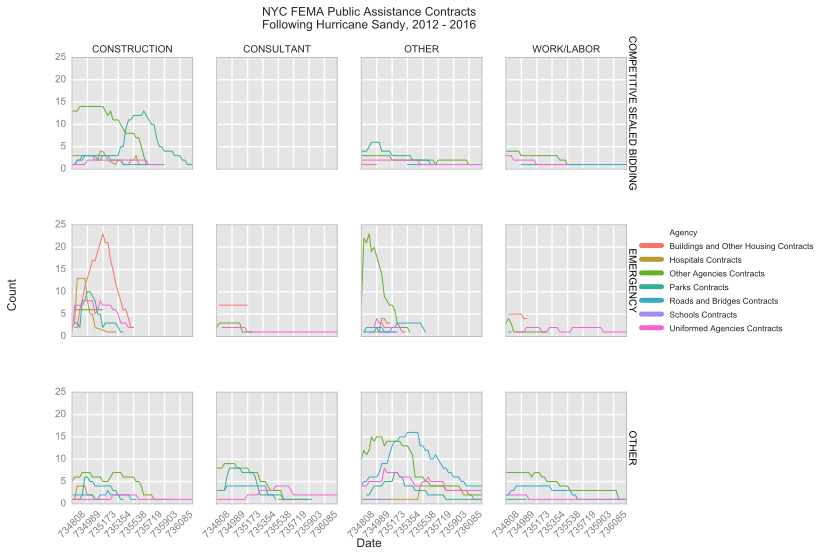

<ggplot: (-9223371927536815272)>

In [123]:
ggplot(fplot_simp,aes(x='Date',y='Count',colour='Agency')) + \
    geom_line() + \
    facet_grid('Procurement Method','Purpose') + \
    theme(axis_text_x  = element_text(angle = 45, hjust = 1)) + \
    ggtitle("NYC FEMA Public Assistance Contracts\nFollowing Hurricane Sandy, 2012 - 2016")

(Unfortunately, the date labels get messed up when they're rotated using `theme`.) 

#### Additional Observations

This figure requires a lot more refinement, *but* with added information on funding purpose and procurement method, we can now tease out a few more details: 

* **Emergency** funding covered some of the spike in projects by **Other Agencies** following Sandy, for tasks other than construction, work/labor, or consultant work. 
* A surge in **Construction** projects was also covered by **Emergency** funding. While active **Hospitals** projects in this category increased immediately after Sandy, for **Buildings/Housing** there is a notable lag in active projects (peaking mid-late 2013). Interestingly, several active **Consultant** work cases covered by emergency funding precede this lag in Buildings/Housing construction. 
* **Competitive Sealed Bidding** (projects requiring 1k USD in funding) are active for **Other Agencies** for awhile after Sandy (suggesting contract work). The mid-2013 spike in **Parks** contracts is also visible in this category. 